# Jazz Improvisation

Generating Jazz solos using LSTM's.

_PyTorch implementation of the assignment of Course 5 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data import generate_music, load_data
from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that will provide the following:

- Each sample is a sequence of **30 musical values** (or notes); each one represented as a **one-hot vector** of 78 unique values
- Each corresponding target is the same as the training sample, shifted one to the right
  - We shift the musical values because we want to predict the next most likely value given some previous one
- 60 training examples
- 78 unique musical values

In [4]:
n_values = 78

In [5]:
class JazzDataset(Dataset):
    def __init__(self):
        self.X, self.y, _, _ = load_data()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = torch.tensor(self.X[idx, :]).float()
        y = torch.tensor(self.y[idx]).long()

        return X, y

We can now create the training set.

In [6]:
training = DataLoader(JazzDataset(), batch_size=30, shuffle=True, num_workers=4)

## Model

We'll use an LSTM with a **single** recurrent layer with **64 units**, and a **softmax** output function at _each_ RNN cell. This means our model expects $T_x = T_y$, i.e. the length of the input sequence should match the length of the target sequence. The reason is that we are generating a model using the _same_ music sample as both input and target (shifted).

![](img/model.png)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # LSTM layer expects one-hot encoded sequences of size `n_values`
        self.lstm = nn.LSTM(input_size=n_values, hidden_size=64, batch_first=True)
        # Output layer to convert to target space (`n_values` note classes)
        self.out = nn.Linear(in_features=64, out_features=n_values)
        # We don't define a softmax output layer explicitly because it's combined with the loss function

    def forward(self, input, state):
        # Pass through LSTM along with the previous hidden activations and cell state
        # Passing in the previous hidden activations and cell states is needed for the model to continue learning
        # if they aren't passed, the activations/cell states are reset to zero which effectively erases any learnings from the model!
        output, state = self.lstm(input, state)
        # Stack outputs from LSTM (i.e. batch_size * seq_len, hidden_size) and convert to target space
        output = self.out(output.contiguous().view(-1, 64))

        return output, state

In [8]:
model = Model()
print(model)

Model(
  (lstm): LSTM(78, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=78, bias=True)
)


## Sampling

In order to generate Jazz solos, we will sample musical values from our model according to their softmax distribution; taking the value with the **highest** probability. We want to do this greedy sampling because it ensures that the generated music "makes sense". This is different from other sampling techniques, e.g. in the case of text generation, where we sample according to the distribution to allow some randomness.

In [9]:
def sample_notes(num_notes=100):
    # Initialize the input as a sample with value zero of size (batch_size=1, seq_len=1, n_values)
    input = torch.zeros([1, 1, n_values]).float()
    # The hidden activations and cell state are initialized to all zeroes by default when `None` is passed
    state = None

    indices = []

    # Make sure to not record any computation in the graph since the model is being used for inference here!
    with torch.no_grad():
        for _ in range(num_notes):
            output, state = model(input.to(device), state)
            output = output.detach().cpu()

            # Compute the distribution using the softmax function
            probs = F.softmax(output, dim=1)
            # We squeeze the output to effectively convert it into a vector
            probs = probs.numpy().squeeze()

            # Sample the musical index greedily
            idx = np.argmax(probs, axis=-1)

            indices.append(idx)

            # The sampled index becomes the input to the next timestep as a one-hot encoded vector
            # Make sure to add the batch_size=1 and seq_len=1 dimensions
            input = F.one_hot(torch.tensor(idx), num_classes=n_values).float().unsqueeze(0).unsqueeze(1)

    return np.array(indices)

## Optimization

We'll use Adam for training the model with the cross-entropy loss. As in the Deep Learning Specialization assignment, we will also add an exponential decay scheduler to reduce the learning rate by 0.01.

In [10]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

## Training

Time to train the model!

In [11]:
# Training configuration
epochs = 100

[0/100]	Loss: 4.331540107727051
[10/100]	Loss: 4.221959114074707
[20/100]	Loss: 4.221946716308594
[30/100]	Loss: 4.221927642822266
[40/100]	Loss: 4.22196102142334
[50/100]	Loss: 4.22197151184082
[60/100]	Loss: 4.221979141235352
[70/100]	Loss: 4.222063064575195
[80/100]	Loss: 4.221956729888916
[90/100]	Loss: 4.221993446350098


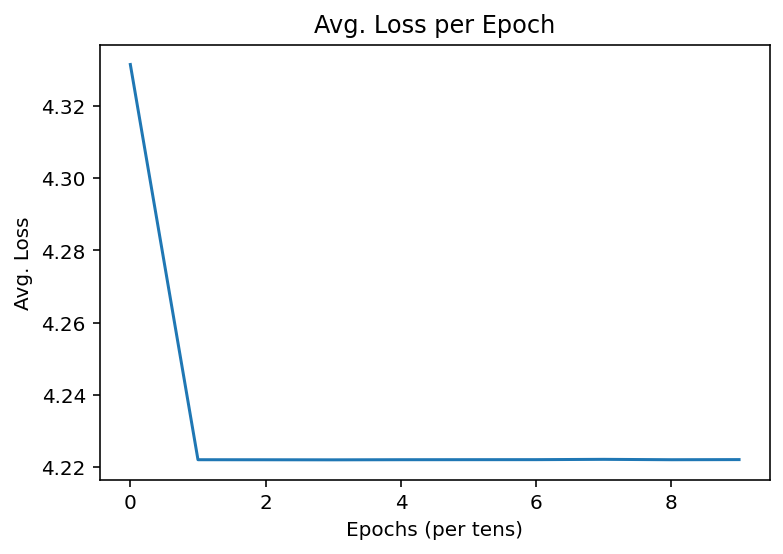

In [12]:
# Main training loop
model = model.to(device)
total_losses = []
# The hidden and cell states are initialized to zeroes when `None` is passed
state = None

for epoch in range(epochs):
    losses = []

    for samples, targets in training:
        optimizer.zero_grad()

        samples = samples.to(device)
        targets = targets.to(device)
        # Flatten the targets to match batch_size * seq_len so the loss can be computed
        targets = targets.flatten()

        output, state = model(samples, state)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

        # Detach the hidden and cell states to avoid saving more computations on them since we'll only use it for initializing the next sequence
        # If we don't detach PyTorch tries to backprop through all the history of states which isn't allowed since the resources are freed
        # We use `detach_()` so the operation is in-place
        state[0].detach_()
        state[1].detach_()

    # Decay learning rate every epoch
    scheduler.step()
    
    if epoch % 10 == 0:
        total_losses.append(np.mean(losses))
        print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs (per tens)')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can use it to sample new jazz music.

In [13]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

generate_music(sample_notes)

Predicting new values for different set of chords.
Generated 101 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 101 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 101 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 101 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 100 sounds using the predicted values for the set of chords ("5") and after pruning
Generated music is saved in output/jazz.midi
